# Jakub Kucharzewski
# Projekt - Prognozowanie zużycia energii przy pomocy Decision Tree, Random Forest oraz XGBoost

Poniższy kod przedstawia proces analizy i modelowania danych na zbiorze danych Energy Consumption Prediction, który pochodzi ze strony Kaggle. Celem jest przewidywanie zużycia energii na podstawie różnorodnych cech, takich jak godzina, miesiąc, dzień tygodnia, oraz inne zmienne dotyczące użytkowania urządzeń HVAC czy oświetlenia.

## Analiza danych

Na początku wczytuję dane z pliku csv.

In [1]:
import pandas as pd
energy_data = pd.read_csv('C:/Users/Kucha/PycharmProjects/pythonProject2/Energy_consumption_dataset.csv')

In [2]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              5000 non-null   int64  
 1   Hour               5000 non-null   int64  
 2   DayOfWeek          5000 non-null   object 
 3   Holiday            5000 non-null   object 
 4   Temperature        5000 non-null   float64
 5   Humidity           5000 non-null   float64
 6   SquareFootage      5000 non-null   float64
 7   Occupancy          5000 non-null   int64  
 8   HVACUsage          5000 non-null   object 
 9   LightingUsage      5000 non-null   object 
 10  RenewableEnergy    5000 non-null   float64
 11  EnergyConsumption  5000 non-null   float64
dtypes: float64(5), int64(3), object(4)
memory usage: 468.9+ KB


In [3]:
energy_data.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,1,0,Saturday,No,25.139433,43.431581,1565.693999,5,On,Off,2.774699,75.364373
1,1,1,Saturday,No,27.731651,54.225919,1411.064918,1,On,On,21.831384,83.401855
2,1,2,Saturday,No,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,78.270888
3,1,3,Saturday,No,20.080469,50.371637,1452.316318,1,Off,On,8.623447,56.519850
4,1,4,Saturday,No,23.097359,51.401421,1094.130359,9,On,Off,3.071969,70.811732


Zmienne ***DayOfWeek***, ***Holiday***, ***HVACUsage***, ***LightingUsage*** mają typ object, zatem niezbędne będzie przekształcenie ich na wartości numeryczne, aby mogły być wykorzystane w procesie uczenia modelu w kolejnych etapach. Przykładowo dla zmiennej ***HVACUsage***, ustawiam On = 1, Off = 0.

In [4]:
pd.set_option('future.no_silent_downcasting', True)

# Konwersja zmiennych binarnych na numeryczne
binary_columns = {'Holiday': {"Yes": 1, "No": 0}, 'HVACUsage': {"On": 1, "Off": 0}, 'LightingUsage': {"On": 1, "Off": 0}}
for col, mapping in binary_columns.items():
    energy_data[col] = energy_data[col].replace(mapping).astype(int)

# Oznaczenie dni tygodnia liczbami
energy_data['DayOfWeek'] = energy_data['DayOfWeek'].replace({"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4,  "Saturday": 5, "Sunday": 6,}).astype(int)
energy_data.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,1,0,5,0,25.139433,43.431581,1565.693999,5,1,0,2.774699,75.364373
1,1,1,5,0,27.731651,54.225919,1411.064918,1,1,1,21.831384,83.401855
2,1,2,5,0,28.704277,58.907658,1755.715009,2,0,0,6.764672,78.270888
3,1,3,5,0,20.080469,50.371637,1452.316318,1,0,1,8.623447,56.519850
4,1,4,5,0,23.097359,51.401421,1094.130359,9,1,0,3.071969,70.811732


Sprawdzę teraz jak zużycie energii zmienia się w na przestrzeni miesięcy, dni tygodnia oraz godzin w ciągu dnia. W tym celu obliczę średnie wartości zużycia w zależności od zmiennej. 

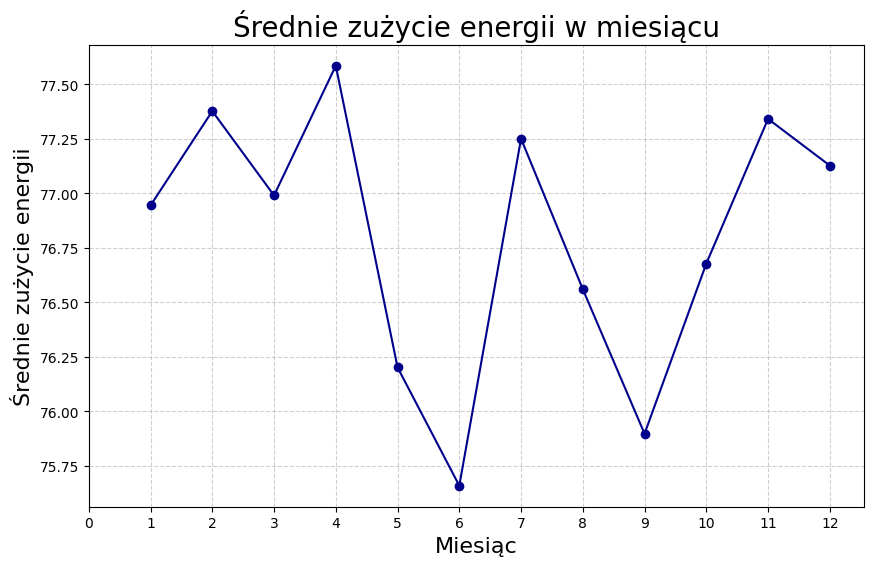

In [5]:
import matplotlib.pyplot as plt

#
month_avg_consumption = energy_data.groupby('Month')['EnergyConsumption'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(month_avg_consumption['Month'], month_avg_consumption['EnergyConsumption'], marker='o', linestyle='-', color='darkblue')
plt.title('Średnie zużycie energii w miesiącu', fontsize=20)
plt.xlabel('Miesiąc', fontsize=16)
plt.ylabel('Średnie zużycie energii', fontsize=16)
plt.xticks(range(0, 13))
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

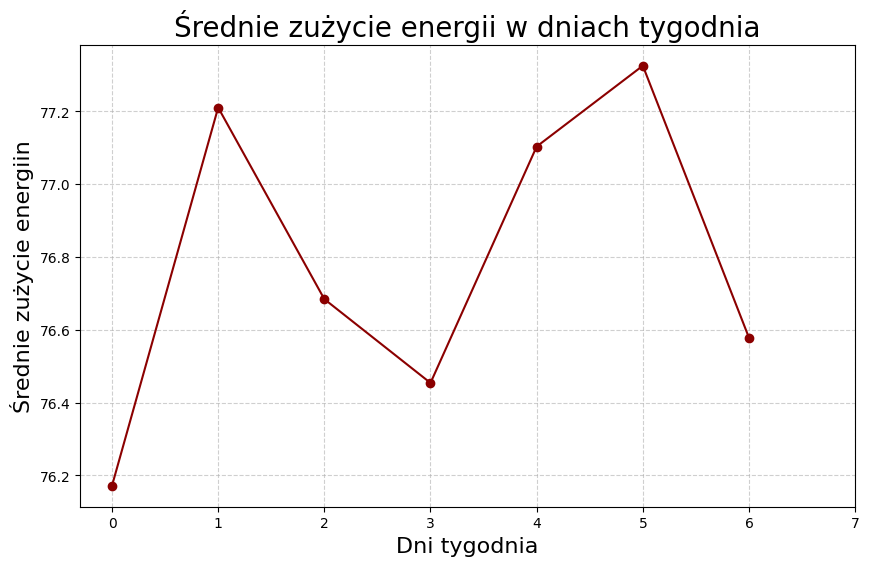

In [6]:
day_avg_consumption = energy_data.groupby('DayOfWeek')['EnergyConsumption'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(day_avg_consumption['DayOfWeek'], day_avg_consumption['EnergyConsumption'], marker='o', linestyle='-', color='darkred')
plt.title('Średnie zużycie energii w dniach tygodnia', fontsize=20)
plt.xlabel('Dni tygodnia', fontsize=16)
plt.ylabel('Średnie zużycie energiin', fontsize=16)
plt.xticks(range(0, 8))
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()


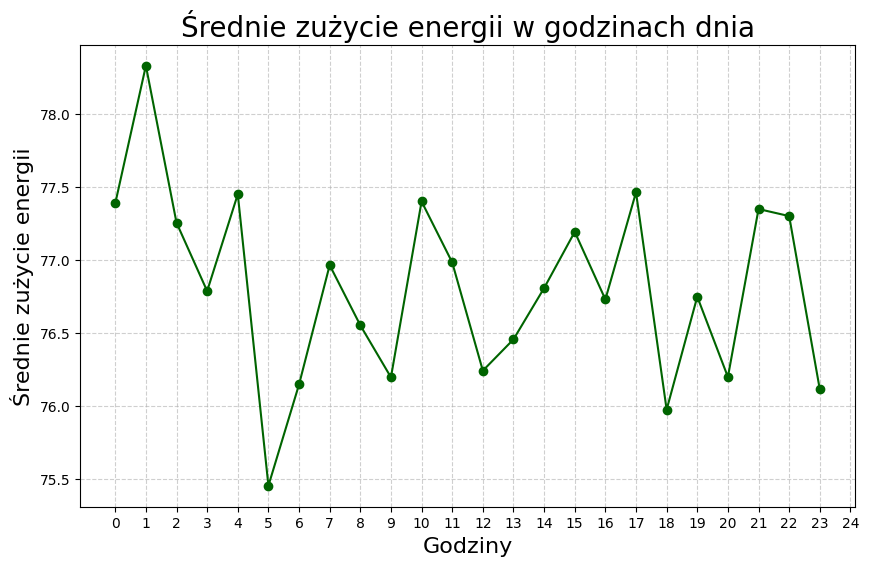

In [7]:
hour_avg_consumption = energy_data.groupby('Hour')['EnergyConsumption'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(hour_avg_consumption['Hour'], hour_avg_consumption['EnergyConsumption'], marker='o', linestyle='-', color='darkgreen')
plt.title('Średnie zużycie energii w godzinach dnia', fontsize=20)
plt.xlabel('Godziny', fontsize=16)
plt.ylabel('Średnie zużycie energii', fontsize=16)
plt.xticks(range(0, 25))
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()


W każdym przypadku wartości średnich są stabilne, a ich zakresy nie są szerokie. Najmniejszy zakres występuje w przypadku dni tygodnia, gdzie wartości mieszczą się w granicach od 76 do 78, zatem wpływ zmiennej "DayOfWeek" może być mało znaczący. 

Jako że te zmienne są ***kategoryczne*** i między nimi nie ma żadnej naturalnej hierarchii ani logicznego porządku, wymagane jest użycie techniki przekształcania zmiennych kategorycznych ***One-Hot encoding***.

**One-Hot Encoding** to technika przekształcania zmiennych kategorycznych na formę numeryczną, która może być wykorzystana przez modele uczenia maszynowego. Polega na reprezentowaniu każdej unikalnej kategorii danej zmiennej jako oddzielną kolumnę (cechę) z wartościami 0 lub 1, gdzie:
- 1 oznacza obecność danej kategorii w danym wierszu,
- 0 oznacza brak tej kategorii w danym wierszu.

Wadą tej techniki jest, że jeśli zmienna ma wiele unikalnych kategorii, liczba kolumn może znacząco wzrosnąć, co może prowadzić do problemów z pamięcią i wydajnością. Dlatego decyduję się usunąć zmienną ***DayOfWeek***. Zmienne ***Month*** i ***Hour*** przekształcę na ***Season*** i ***TimeOfDay***, aby zmniejszyć liczbę unikalnych kategorii.
- Miesiące przekształcam na porę roku, do której dany miesiąc należy: 1 - zima, 2 - wiosna, itd.
- Godziny przekształcam na pory dnia: 1 - rano, 2 - popołudnie, itd.

In [8]:
#Miesiące przekształca na porę roku do której dany miesiąc należy. 1 - zima, 2 - wiosna itd.
def pora_roku(month):
    if 1 <= month < 3 or month == 12:
        return '1'
    elif 3 <= month < 7:
        return '2'
    elif 7 <= month < 10:
        return '3'
    else:
        return '4'

#Godziny przekształca na pory dnia, do ktorej dana godzina należy. 1 - rano, 2 - popołudnie itd.
def pora_dnia(hour):
    if 4 <= hour < 12:
        return '1'
    elif 12 <= hour < 16:
        return '2'
    elif 16 <= hour < 21:
        return '3'
    else:
        return '4'

In [9]:
#Przekształacam zmienne przy pomocy powyższych funkcji.
energy_data['TimeOfDay'] = energy_data['Hour'].apply(pora_dnia)
energy_data['Season'] = energy_data['Month'].apply(pora_roku)
energy_data = energy_data.drop('Hour', axis=1)
energy_data = energy_data.drop('Month', axis=1)
print(energy_data.columns)
print(energy_data[['TimeOfDay', 'Season']])

Index(['DayOfWeek', 'Holiday', 'Temperature', 'Humidity', 'SquareFootage',
       'Occupancy', 'HVACUsage', 'LightingUsage', 'RenewableEnergy',
       'EnergyConsumption', 'TimeOfDay', 'Season'],
      dtype='object')
     TimeOfDay Season
0            4      1
1            4      1
2            4      1
3            4      1
4            1      1
...        ...    ...
4995         1      1
4996         3      1
4997         2      1
4998         1      1
4999         4      1

[5000 rows x 2 columns]


In [10]:
#One-Hot encoding
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(energy_data[['TimeOfDay']]))
OH_cols1 = pd.DataFrame(OH_encoder.fit_transform(energy_data[['Season']]))
OH_cols.columns = [f"TimeOfDay_{i}" for i in range(OH_cols.shape[1])]
OH_cols1.columns = [f"Season_{i}" for i in range(OH_cols.shape[1])]
OH_cols.index = energy_data.index
OH_cols1.index = energy_data.index

In [11]:
#Złączenie powstałych tabel oraz usunięcie tych pierwotnych.
energy_data_oh = pd.concat([energy_data, OH_cols, OH_cols1], axis=1)
energy_data_oh = energy_data_oh.drop('TimeOfDay', axis=1)
energy_data_oh = energy_data_oh.drop('Season', axis=1)

#Usunięcie zmiennej DayOfWeek
energy_data_oh = energy_data_oh.drop('DayOfWeek', axis=1)
energy_data_oh.head()

,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption,TimeOfDay_0,TimeOfDay_1,TimeOfDay_2,TimeOfDay_3,Season_0,Season_1,Season_2,Season_3
0,0,25.139433,43.431581,1565.693999,5,1,0,2.774699,75.364373,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0,27.731651,54.225919,1411.064918,1,1,1,21.831384,83.401855,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0,28.704277,58.907658,1755.715009,2,0,0,6.764672,78.270888,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0,20.080469,50.371637,1452.316318,1,0,1,8.623447,56.519850,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0,23.097359,51.401421,1094.130359,9,1,0,3.071969,70.811732,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Tworzenie modelu

Definiuję zmienne cech i zmienną docelową:

In [12]:
features = [col for col in energy_data_oh.columns if col != 'EnergyConsumption']
X = energy_data_oh[features]
y = energy_data_oh['EnergyConsumption']

Dane rozdzielam na zestaw treningowy i testowy:

In [13]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1)

Dane będę trenował na wielu modelach z różnymi kryteriami, aby wyodrębnić ten najlepszy. W tym celu tworzę funkcję, które będzie oceniać modele na podstawie miar oceny jakości modeli regresyjnych: ***Mean Absolute Error***, ***Mean Squared Error***, ***R-squared***.

1. ***Mean Absolute Error*** mierzy średnią różnicę (błąd) między przewidywaniami modelu a rzeczywistymi wartościami. Wartość MAE jest średnią z bezwzględnych różnic (absolutnych błędów) pomiędzy wartościami rzeczywistymi a przewidywaniami modelu.
   - Im wyższa wartość MAE, tym **gorsza** jakość modelu.
2. ***Mean Squared Error*** mierzy średnią z kwadratów różnic między przewidywanymi wartościami a rzeczywistymi. W przeciwieństwie do MAE, MSE daje większą wagę większym błędom, ponieważ różnice są podnoszone do kwadratu.
   - Im wyższa wartość MSE, tym **gorsze** dopasowanie modelu.
3. ***R-squared*** (R²) to miara, która wskazuje, jaka część zmienności zmiennej zależnej (y) jest wyjaśniana przez model regresyjny. Mówiąc prościej, mierzy, jak dobrze model dopasowuje się do danych.
   - Przedział wartości to [0,1]
   - Im wyższa wartość, tym **lepsze** dopasowanie modelu.

In [14]:
# Funkcja do oceny modeli
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    return mae, r2, mse

# Funkcja do testowania różnych modeli i parametrów
def test_models(model_class, param_name, param_values, X_train, X_test, y_train, y_test, model_name="Model"):
    print(f"\n{model_name}:")
    for param in param_values:
        model = model_class(**{param_name: param}, random_state=0) if model_class != XGBRegressor else model_class(**{param_name: param, 'learning_rate': 0.1, 'max_depth': 5,'n_jobs': 4})
        mae, r2, mse = evaluate_model(model, X_train, X_test, y_train, y_test)
        print(f"{param}: MAE = {mae:.4f}, MSE = {mse:.4f}, R2 = {r2:.4f}")

In [15]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

#### Decision Tree

***Decision Tree*** (drzewo decyzyjne) to algorytm uczenia maszynowego stosowany do problemów regresji i klasyfikacji, który działa na zasadzie podejmowania decyzji na podstawie wartości cech. Drzewo decyzyjne jest strukturą przypominającą drzewo, w którym:
- Korzeń (root) to początkowa decyzja (punkt podziału),
- Gałęzie (branches) reprezentują możliwe opcje do podjęcia (wyniki decyzji),
- Węzły (nodes) to miejsca, w których dokonywane są decyzje (warunki na cechach),
- Liście (leaves) to końcowe wyniki, np. klasyfikacje lub wartości przewidywane.

Ilość liści w drzewie decyzyjnym ma istotne znaczenie, ponieważ wpływa na zdolność modelu do generalizowania i dokładność jego prognoz. Zbyt duża liczba liści może prowadzić do przeuczenia (overfitting), natomiast zbyt mała liczba liści może sprawić, że model będzie zbyt ogólny, co prowadzi do niedouczenia (underfitting).

Sprawdzam, zatem jaka ilość jest najlepsza.

In [16]:
leafs = [10, 20, 30, 50, 100, 150]
test_models(DecisionTreeRegressor, "max_leaf_nodes", leafs, train_X, test_X, train_y, test_y, "Decision Tree")


Decision Tree:
10: MAE = 6.3904, MSE = 63.3274, R2 = 0.2771
20: MAE = 6.3456, MSE = 62.5705, R2 = 0.2857
30: MAE = 6.4038, MSE = 64.7190, R2 = 0.2612
50: MAE = 6.5320, MSE = 68.8064, R2 = 0.2145
100: MAE = 6.8476, MSE = 75.3104, R2 = 0.1403
150: MAE = 7.0404, MSE = 81.1262, R2 = 0.0739


Najlepszy wynik dla 20 liści.

#### Random Forest

***Random Forest*** to algorytm uczenia maszynowego, który jest oparty na lasach drzew decyzyjnych. Zasadniczo, Random Forest tworzy wiele drzew decyzyjnych i łączy ich wyniki w celu uzyskania bardziej stabilnych i dokładnych prognoz.

Tak samo jak wcześniej, szukam najlepszej ilości liści.

In [17]:
estimators = [100, 200, 250, 325]
test_models(RandomForestRegressor, "n_estimators", estimators, train_X, test_X, train_y, test_y, "Random Forest")


Random Forest:
100: MAE = 6.2653, MSE = 62.4093, R2 = 0.2875
200: MAE = 6.2365, MSE = 61.8150, R2 = 0.2943
250: MAE = 6.2334, MSE = 61.6448, R2 = 0.2963
325: MAE = 6.2266, MSE = 61.5960, R2 = 0.2968


Najlepszy wynik dla 250 liści.

#### XGBoost

***XGBoost*** (Extreme Gradient Boosting) to jeden z najpopularniejszych i najbardziej wydajnych algorytmów uczenia maszynowego, szczególnie w zadaniach klasyfikacji i regresji. Jest to implementacja algorytmu gradient boosting, który tworzy silny model poprzez łączenie wyników wielu słabych modeli. Ważne parametry:
- **n_estimators**: Liczba drzew w modelu.
- **learning_rate** (eta): Współczynnik uczenia, który kontroluje, jak duży krok algorytm stawia w kierunku minimalizacji błędów.

Szukam najlepszej ilości **n_estimators**.

In [18]:
estimators = [10, 20, 30, 40, 45, 70]
test_models(XGBRegressor, "n_estimators", estimators, train_X, test_X, train_y, test_y, "XGBoost")


XGBoost:
10: MAE = 6.4653, MSE = 64.2426, R2 = 0.2666
20: MAE = 6.2831, MSE = 61.1939, R2 = 0.3014
30: MAE = 6.2263, MSE = 60.5705, R2 = 0.3085
40: MAE = 6.2064, MSE = 60.4973, R2 = 0.3094
45: MAE = 6.2059, MSE = 60.5236, R2 = 0.3091
70: MAE = 6.2018, MSE = 60.8672, R2 = 0.3052


Najlepszy wynik dla 30. Jest to również najlepszy wynik spośród wszystkich modeli.

In [21]:
best_model = XGBRegressor(n_estimators=30, learning_rate=0.1, max_depth=5, n_jobs=4)
best_model.fit(train_X, train_y)
predcitions = best_model.predict(test_X)
mae = mean_absolute_error(test_y, predcitions)
mse = mean_squared_error(test_y, predcitions)
r2 = r2_score(test_y, predcitions)
print(f"MAE: {mae}, MSE: {mse}, R Squared: {r2}")

MAE: 6.22626272239104, MSE: 60.570490232280534, R Squared: 0.3085370322595229


Sprawdźmy teraz jak prezentują się predykcje na wykresie.

         Actual  Predicted
2764  77.205545  71.806404
4767  82.558564  83.558510
3814  82.016733  77.673378
3499  70.443806  82.378662
2735  74.960150  82.807838


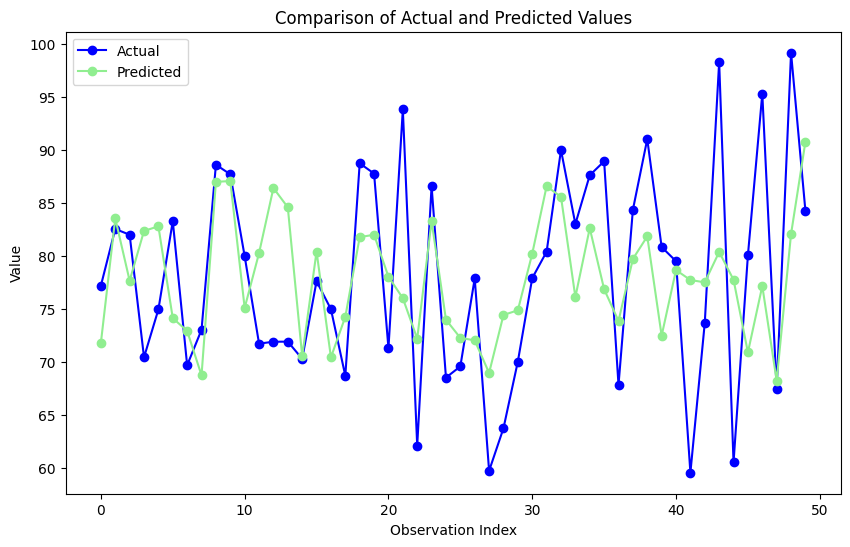

In [20]:
# Tworzenie DataFrame do porównania
comparison_df = pd.DataFrame({'Actual': test_y, 'Predicted': predcitions})

# Wyświetlanie pierwszych kilku wierszy
print(comparison_df.head())

# Ograniczenie danych do pierwszych 50 wartości
limited_test_y = test_y[:50]
limited_predictions = predcitions[:50]

plt.figure(figsize=(10, 6))
plt.plot(limited_test_y.values, label='Actual', marker='o', color='blue')
plt.plot(limited_predictions, label='Predicted', marker='o', color='lightgreen')
plt.xlabel('Observation Index')
plt.ylabel('Value')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

## Podsumowanie

Model XGBRegressor daje średnie wyniki (MAE = 6.22, R² = 0.311) w przewidywaniu zużycia energii. Choć model jest w stanie generować przyzwoite prognozy, to jego dokładność jest ograniczona.
Niska wartość R² wskazuje na potrzebę poprawy modelu, a najlepszą drogą może być dalsze strojenie parametrów, dodanie nowych cech oraz eksperymentowanie z innymi algorytmami.